# Credit Card Lead Prediction

Task:
Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.

The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 

In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.

Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

* Customer details (gender, age, region etc.)
* Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)

**Evaluation**
The evaluation metric for this competition is roc_auc_score across all entries in the test set.

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


# Import Sklearn functions
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import tensorflow as tf
print(tf.__version__)

import os

2.4.1


In [7]:
def generate_auc_roc_curve(clf, X_valid):
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_valid,  y_pred_proba)
    auc = sklearn.metrics.roc_auc_score(y_valid, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()

In [8]:
data_directory = '../input/jobathon-may-2021-credit-card-lead-prediction/'

In [9]:
train_df = pd.read_csv(data_directory + 'train.csv')
test_df = pd.read_csv(data_directory + 'test.csv')
sub_df = pd.read_csv(data_directory + 'sample_submission.csv')

In [10]:
train_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [11]:
test_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [12]:
sub_df.head()

,ID,Is_Lead
0,VBENBARO,0
1,CCMEWNKY,0
2,VK3KGA9M,0
3,TT8RPZVC,0
4,SHQZEYTZ,0


In [13]:
train_df.shape,test_df.shape

((245725, 11), (105312, 10))

In [14]:
if (train_df.duplicated().any()) == True:
  duplicated_rows = train_df.duplicated().sum()
  print ('There are {} rows duplicated'.format(str(duplicated_rows)))
else:
  print("No Duplicated rows")

No Duplicated rows


In [15]:
train_df.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


In [16]:
# train_df.isna().sum()
print('Missing values in percentage')
(train_df.isnull().sum() * 100 / len(train_df)).sort_values(ascending=False)

Missing values in percentage


Credit_Product         11.934073
ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Avg_Account_Balance     0.000000
Is_Active               0.000000
Is_Lead                 0.000000
dtype: float64

In [17]:
neg, pos = np.bincount(train_df['Is_Lead'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 245725
    Positive: 58288 (23.72% of total)



In [18]:
print(f'Training data has minimum age as {train_df.Age.min()} and maximum age as {train_df.Age.max()}')

Training data has minimum age as 23 and maximum age as 85


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


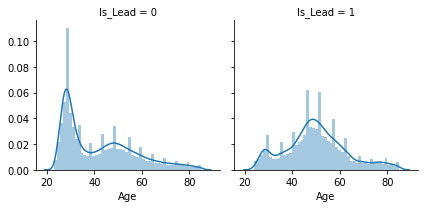

In [19]:
# Explore Age vs Interested
g = sns.FacetGrid(train_df, col='Is_Lead')
g = g.map(sns.distplot, "Age")

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


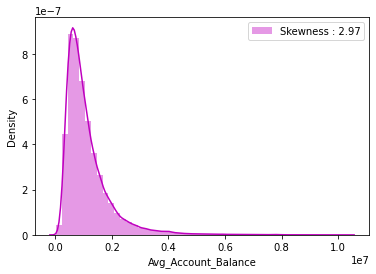

In [20]:
# Explore Fare distribution 
g = sns.distplot(train_df["Avg_Account_Balance"], color="m", label="Skewness : %.2f"%(train_df["Avg_Account_Balance"].skew()))
g = g.legend(loc="best")

In [21]:
train_df["Avg_Account_Balance"].describe()

count    2.457250e+05
mean     1.128403e+06
std      8.529364e+05
min      2.079000e+04
25%      6.043100e+05
50%      8.946010e+05
75%      1.366666e+06
max      1.035201e+07
Name: Avg_Account_Balance, dtype: float64

In [22]:
Q1 = train_df['Avg_Account_Balance'].quantile(0.25)
Q3 = train_df['Avg_Account_Balance'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

762356.0


In [23]:
print('Before ',train_df.shape)
train_df = train_df[~((train_df['Avg_Account_Balance'] < (Q1 - 1.5 * IQR)) |(train_df['Avg_Account_Balance'] > (Q3 + 1.5 * IQR)))]
print('After ',train_df.shape)

Before  (245725, 11)
After  (231113, 11)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


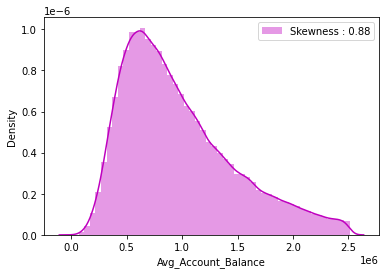

In [24]:
# Explore Fare distribution 
g = sns.distplot(train_df["Avg_Account_Balance"], color="m", label="Skewness : %.2f"%(train_df["Avg_Account_Balance"].skew()))
g = g.legend(loc="best")

In [25]:
# Apply log to Fare to reduce skewness distribution
train_df["Avg_Account_Balance"] = train_df["Avg_Account_Balance"].map(lambda i: np.log(i) if i > 0 else 0)
# train_df["Avg_Account_Balance"] = train_df["Avg_Account_Balance"].astype("int64")

test_df["Avg_Account_Balance"] = test_df["Avg_Account_Balance"].map(lambda i: np.log(i) if i > 0 else 0)
# test_df["Avg_Account_Balance"] = test_df["Avg_Account_Balance"].astype("int64")

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


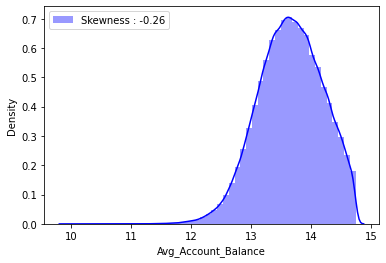

In [26]:
g = sns.distplot(train_df["Avg_Account_Balance"], color="b", label="Skewness : %.2f"%(train_df["Avg_Account_Balance"].skew()))
g = g.legend(loc="best")

In [27]:
train_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,13.860193,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,13.274205,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,14.210464,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,13.061453,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,13.695360,No,0


In [28]:
train_df.drop(['ID'],axis=1,inplace=True)
# test_ids = test_df['ID']
# test_df.drop(['ID'],axis=1,inplace=True)
train_df.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,13.860193,No,0
1,Female,30,RG277,Salaried,X1,32,No,13.274205,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,14.210464,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,13.061453,No,0
4,Female,30,RG282,Salaried,X1,33,No,13.695360,No,0


<AxesSubplot:xlabel='Avg_Account_Balance'>

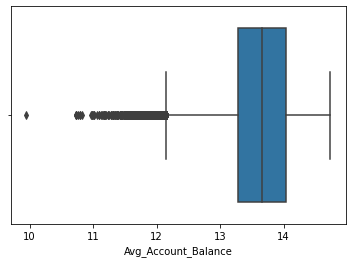

In [29]:
sns.boxplot(x=train_df['Avg_Account_Balance'])

Huge chance of outliers so need to handle this. 

Text(0.5, 1.0, 'Is Lead Distribution')

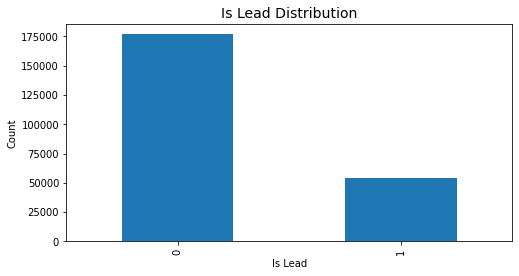

In [30]:
plt.figure(figsize=(8,4))
train_df['Is_Lead'].value_counts().plot(kind = 'bar')
plt.ylabel('Count')
plt.xlabel('Is Lead')
plt.title('Is Lead Distribution',fontsize=14)

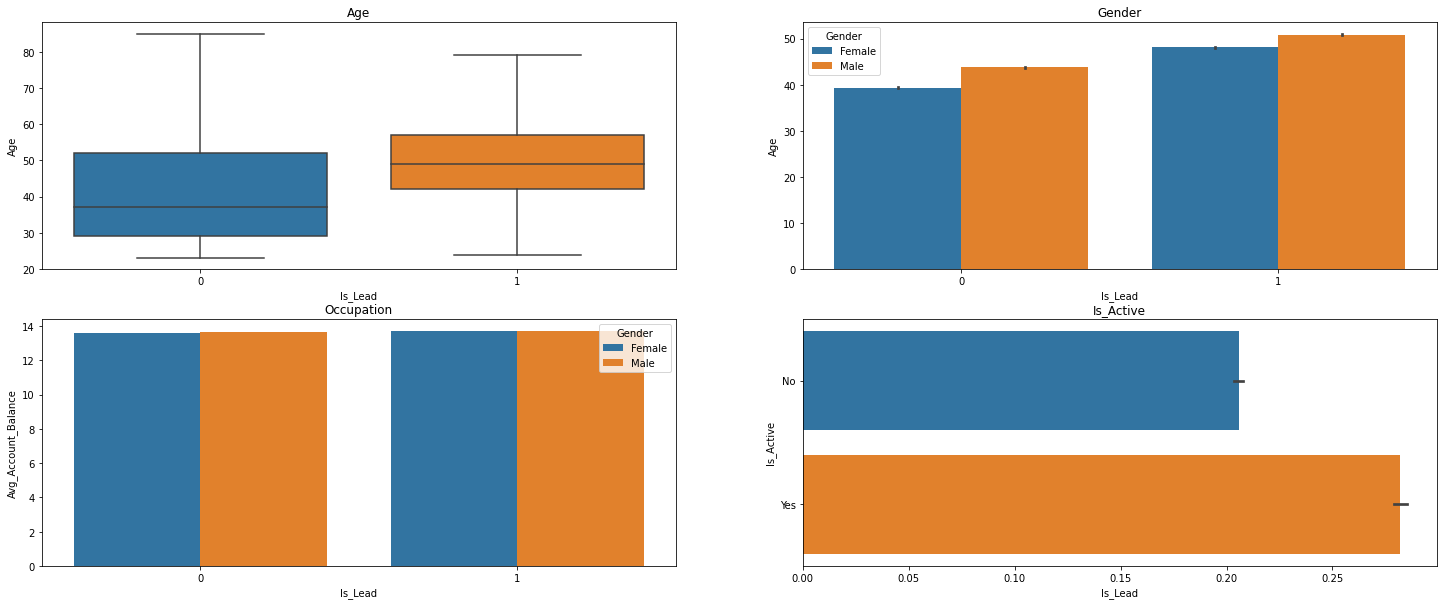

In [31]:
plt.figure(figsize=(25, 10))

# subplot 1
plt.subplot(2, 2, 1)
plt.title('Age')
ax=sns.boxplot(y="Age",x='Is_Lead',data=train_df, showfliers=False)

# subplot 2
plt.subplot(2, 2, 2)
plt.title('Gender')
ax1 = sns.barplot(x="Is_Lead", y="Age", hue="Gender", data=train_df)

# subplot 3
plt.subplot(2, 2, 3)
plt.title('Occupation')
ax1 = sns.barplot(x="Is_Lead", y="Avg_Account_Balance", hue="Gender", data=train_df)


# subplot 3
plt.subplot(2, 2, 4)
plt.title('Is_Active')
ax1=sns.barplot(x="Is_Lead", y="Is_Active", data=train_df)

Categorical to numeric

In [32]:
def categorical_to_numeric(df,column):
    # label_encoder object knows how to understand word labels.
    label_encoder = LabelEncoder()

    # Encode labels in column 'species'.
    label_encoder.fit(df[column])

#     df[column].unique()
#     print(label_encoder.classes_)
    
    return label_encoder

In [33]:
label_encoder_Is_Active = categorical_to_numeric(train_df,"Is_Active")
train_df['Is_Active'] = label_encoder_Is_Active.transform(train_df['Is_Active'])
test_df['Is_Active'] = label_encoder_Is_Active.transform(test_df['Is_Active'])

In [34]:
label_encoder_Region_Code = categorical_to_numeric(train_df,"Region_Code")
train_df['Region_Code'] = label_encoder_Region_Code.transform(train_df['Region_Code'])
test_df['Region_Code'] = label_encoder_Region_Code.transform(test_df['Region_Code'])

In [35]:
label_encoder_Occupation = categorical_to_numeric(train_df,"Occupation")
train_df['Occupation'] = label_encoder_Occupation.transform(train_df['Occupation'])
test_df['Occupation'] = label_encoder_Occupation.transform(test_df['Occupation'])

In [36]:
# train_df.Channel_Code.unique()
label_encoder_Channel_Code = categorical_to_numeric(train_df,"Channel_Code")
train_df['Channel_Code'] = label_encoder_Channel_Code.transform(train_df['Channel_Code'])
test_df['Channel_Code'] = label_encoder_Channel_Code.transform(test_df['Channel_Code'])

In [37]:
# train_df.Gender.unique()
label_encoder_Gender = categorical_to_numeric(train_df,"Gender")
train_df['Gender'] = label_encoder_Gender.transform(train_df['Gender'])
test_df['Gender'] = label_encoder_Gender.transform(test_df['Gender'])

For Credit Product we cant use direct encoding as it has 11% of nan values. So use some mathematical way to fill those nan values and then use label encoder

There are various ways to handle categorical missing data 

Refer: https://medium.com/analytics-vidhya/ways-to-handle-categorical-column-missing-data-its-implementations-15dc4a56893
1. Replace with most frequent categorical value in the column
2. Add a new column and write 1 if value is nan else 0 and fill most frequent value with nan
3. Create a New Category for NAN Values
4. Function to replace with "Yes" or "No"
5. Use ML for computing missing value

In [38]:
# 1. Function to replace NAN values with mode value
def impute_nan_most_frequent_category(DataFrame,ColName):
    # .mode()[0] - gives first category name
     most_frequent_category=DataFrame[ColName].mode()[0]
    
    # replace nan values with most occured category
     DataFrame[ColName + "_Imputed"] = DataFrame[ColName]
     DataFrame[ColName + "_Imputed"].fillna(most_frequent_category,inplace=True)
    
# 2. Function to impute most occured category and add importance variable
def impute_nan_add_vairable(DataFrame,ColName,selection=None):
    #1. add new column and replace if category is null then 1 else 0
    DataFrame[ColName+"_Imputed"] =   np.where(DataFrame[ColName].isnull(),1,0)
    
    # 2. Take most occured category in that vairable (.mode())
    if selection:
        Mode_Category = selection
    else:
        Mode_Category = DataFrame[ColName].mode()[0]
    
    ## 2.1 Replace NAN values with most occured category in actual vairable
    DataFrame[ColName].fillna(Mode_Category,inplace=True)
    
# 3. Function to impute null value with new category
def impute_nan_create_category(DataFrame,ColName):
     DataFrame[ColName] = np.where(DataFrame[ColName].isnull(),"Unknown",DataFrame[ColName])
        
#4. Function to replace with "Yes" or "No"
def impute_with_selection(DataFrame,ColName,selection="Yes"):
    DataFrame[ColName] = np.where(DataFrame[ColName].isnull(),selection,DataFrame[ColName])
    
#5 Use ML for computing missing
def impute_with_ML(DataFrame,test_dataframe,ColName):
    
    X_test2 = test_dataframe[test_dataframe['Credit_Product'].isna()]
    test_dataframe = test_dataframe[~test_dataframe['Credit_Product'].isna()]
    test_dataframe['Credit_Product'] = test_dataframe['Credit_Product'].map({"Yes":1,"No":0})
    
    X_test = DataFrame[DataFrame['Credit_Product'].isna()]
    DataFrame = DataFrame[~DataFrame['Credit_Product'].isna()]
    DataFrame['Credit_Product'] = DataFrame['Credit_Product'].map({"Yes":1,"No":0})
    X = DataFrame.drop(['Credit_Product','Is_Lead'],axis=1)
    y = DataFrame['Credit_Product']
    X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.2, random_state = 0)
    xgb_model = XGBClassifier(
                             learning_rate =0.01,
                             n_estimators=5000,
                             max_depth=4,
                             min_child_weight=6,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             reg_alpha=0.005,
                             objective= 'binary:logistic',
                             nthread=4,
                             scale_pos_weight=1,
                             seed=27).fit(X_train,y_train)
    
    pred = xgb_model.predict_proba(X_valid)[:,1]
    roc_score = roc_auc_score(y_valid,pred)
    print(roc_score)
    
    preds = xgb_model.predict(X_test.drop(['Credit_Product','Is_Lead'],axis=1))
    X_test['Credit_Product'] = preds
    
    preds = xgb_model.predict(X_test2.drop(['Credit_Product','ID'],axis=1))
    X_test2['Credit_Product'] = preds
    
    #adding extra column
    DataFrame['Impute_Credit_Product'] = 0
    X_test['Impute_Credit_Product'] = 1
    
    test_dataframe['Impute_Credit_Product'] = 0
    X_test2['Impute_Credit_Product'] = 1
    
    return pd.concat([DataFrame,X_test]), pd.concat([test_dataframe,X_test2]);
    

In [39]:
train_df.shape,test_df.shape

((231113, 10), (105312, 10))

In [40]:
train_df_new,test_df_new = impute_with_ML(train_df,test_df,"Credit_Product")
train_df_new['Credit_Product'] = train_df_new['Credit_Product'].astype('int64')
test_df_new['Credit_Product'] = test_df_new['Credit_Product'].astype('int64')
train_df_new.shape,test_df_new.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object;

[17:15:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


0.7610654785591118


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packa

((231113, 11), (105312, 11))

In [422]:
# impute_nan_most_frequent_category(DataFrame,ColName)
# impute_nan_create_category(DataFrame,ColName)

# impute_nan_add_vairable(train_df,"Credit_Product","Yes")
# impute_nan_add_vairable(test_df,"Credit_Product","Yes")

# impute_nan_create_category(train_df,"Credit_Product")
# impute_nan_create_category(test_df,"Credit_Product")

# impute_with_selection(train_df,"Credit_Product","Yes")
# impute_with_selection(test_df,"Credit_Product","Yes")

# Display top 10 row to see the result of imputation
# train_df[['Credit_Product','Credit_Product_Imputed']].head(10)

In [366]:
# label_encoder_Credit_Product = categorical_to_numeric(train_df,"Credit_Product")

# train_df['Credit_Product'] = label_encoder_Credit_Product.transform(train_df['Credit_Product'])
# test_df['Credit_Product'] = label_encoder_Credit_Product.transform(test_df['Credit_Product'])

In [41]:
train_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231113 entries, 0 to 245720
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Gender                 231113 non-null  int64  
 1   Age                    231113 non-null  int64  
 2   Region_Code            231113 non-null  int64  
 3   Occupation             231113 non-null  int64  
 4   Channel_Code           231113 non-null  int64  
 5   Vintage                231113 non-null  int64  
 6   Credit_Product         231113 non-null  int64  
 7   Avg_Account_Balance    231113 non-null  float64
 8   Is_Active              231113 non-null  int64  
 9   Is_Lead                231113 non-null  int64  
 10  Impute_Credit_Product  231113 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 21.2 MB


In [42]:
new_train_df = train_df_new.copy()

In [43]:
new_train_df.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Impute_Credit_Product
0,0,73,18,1,2,43,0,13.860193,0,0,0
1,0,30,27,2,0,32,0,13.274205,0,0,0
2,0,56,18,3,2,26,0,14.210464,1,0,0
3,1,34,20,2,0,19,0,13.061453,0,0,0
4,0,30,32,2,0,33,0,13.695360,0,0,0


<AxesSubplot:>

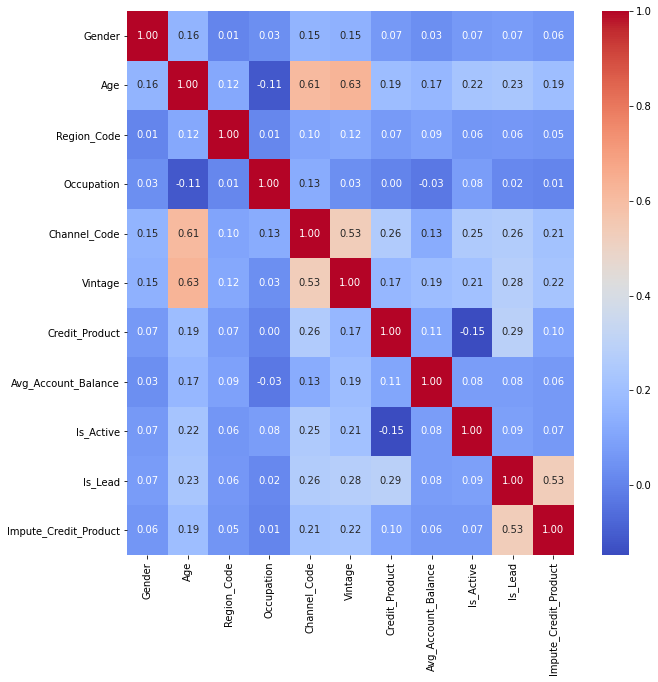

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(new_train_df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm",ax=ax)

In [45]:
X = new_train_df.drop(['Is_Lead'],axis=1,inplace=False)
y = new_train_df['Is_Lead']

In [46]:
test_ids = test_df_new['ID']
X_test = test_df_new.drop(['ID'],axis=1)

In [47]:
# scaler = sklearn.preprocessing.StandardScaler()
# # X = scaler.fit_transform(X)
# X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)
# X_test =  pd.DataFrame(scaler.transform(test_df),columns = test_df.columns)

In [48]:
not_interested,interested = y.value_counts()

print(f'If the Customer is interested for the Credit Card\n\
\t value 0 means Customer is not interested. Total count {not_interested}\n\
\t value 1 means Customer is interested. Total count {interested}')

If the Customer is interested for the Credit Card
	 value 0 means Customer is not interested. Total count 176791
	 value 1 means Customer is interested. Total count 54322


In [49]:
# Whole dataset
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.33, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions valid dataset: ", len(X_valid))
print("Total number of transactions: ", len(X_train)+len(X_valid))

Number transactions train dataset:  154845
Number transactions valid dataset:  76268
Total number of transactions:  231113


In [50]:
def custom_sampling(X,y,strategy):
    
    strategy = strategy.lower()
    if strategy=='undersampling':
        rus = RandomUnderSampler(random_state=42, replacement=True)
        X_sampled, y_sampled = rus.fit_resample(X, y)
    elif strategy == 'oversampling':
        ros =  RandomOverSampler(random_state=42)
        X_sampled, y_sampled = ros.fit_resample(X, y)
    elif strategy == 'smote':
        sm = SMOTE(random_state = 42)
        X_sampled, y_sampled = sm.fit_resample(X, y)
    else:
        print('Enter correct sampling strategy... \nPick from this list[undersampling,oversampling,smote]')
    
    print('Original dataset shape {}'.format(Counter(y)))
    print('Resampled dataset shape {}'.format(Counter(y_sampled)))
    
    return X_sampled,y_sampled

In [592]:
# X_train,y_train = custom_sampling(X_train,y_train,strategy='SMOTE')
# X_train,y_train = custom_sampling(X,y,strategy='SMOTE')

In [51]:
X_data = X
y_data = y

In [52]:
not_interested,interested = y_data.value_counts()

print(f'If the Customer is interested for the Credit Card\n\
\t value 0 means Customer is not interested. Total count {not_interested}\n\
\t value 1 means Customer is interested. Total count {interested}')

If the Customer is interested for the Credit Card
	 value 0 means Customer is not interested. Total count 176791
	 value 1 means Customer is interested. Total count 54322


Modelling

In [53]:
def run_ml_model(X_data,y_data,model_name,model):
    import sys

    if not sys.warnoptions:
        import warnings
        warnings.simplefilter("ignore")
    
    if model_name is not None and model_name !="Random Forest":
        try:
            model.fit(X_data,y_data,verbose=0)
        except:
            model.fit(X_data,y_data)
        y_pred = model.predict_proba(X_valid)[:,1]
        score = sklearn.metrics.roc_auc_score(y_valid,y_pred)
        return model,score
    elif model_name=="Random Forest":  # known issue for random forest(https://github.com/ray-project/tune-sklearn/issues/186)
        model = RandomForestClassifier(min_samples_split= 1800,
                       n_estimators= 300,
                       criterion= 'entropy',
                       max_depth= 36,
                       min_samples_leaf=810, 
                       random_state=100)
        model.fit(X_data,y_data)
        y_pred = model.predict_proba(X_valid)[:,1]
        score = sklearn.metrics.roc_auc_score(y_valid,y_pred)
        return model,score
    else:
        print('Entry correct model name')
    return

In [54]:
my_models_dict = {
            "Logistic Regression": LogisticRegression(verbose=0),
            "Decision Tree": DecisionTreeClassifier(max_depth= 15, max_features= 5),
            "Random Forest": "",
            "GaussainNB":GaussianNB(var_smoothing=1.0),
            "AdaBoost":AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',splitter='random'),
                       learning_rate=0.001, n_estimators=2, random_state=7),
            "LGBMClassifier": LGBMClassifier(),
            "XGBClassifier": XGBClassifier(verbose=0),
            "CatBoostClassifier": CatBoostClassifier()
          
          }
my_models_score = {}
my_models_dict

for model_name,curr_model in tqdm(my_models_dict.items()):
#     print(model_name,curr_model)
    model,score = run_ml_model(X_data,y_data,model_name,curr_model)
#     print(f'Model {model_name} has AUC score {round(score,2)}')
    my_models_score[model_name] = {"model":model,"auc_score":score}
    
my_models_score

 75%|███████▌  | 6/8 [01:12<00:20, 10.14s/it]

[17:23:25] WARNING: ../src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:23:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 8/8 [02:08<00:00, 16.04s/it]


{'Logistic Regression': {'model': LogisticRegression(),
  'auc_score': 0.8530653586390944},
 'Decision Tree': {'model': DecisionTreeClassifier(max_depth=15, max_features=5),
  'auc_score': 0.9063793642540225},
 'Random Forest': {'model': RandomForestClassifier(criterion='entropy', max_depth=36, min_samples_leaf=810,
                         min_samples_split=1800, n_estimators=300,
                         random_state=100),
  'auc_score': 0.8700177052560687},
 'GaussainNB': {'model': GaussianNB(var_smoothing=1.0),
  'auc_score': 0.6977708966896202},
 'AdaBoost': {'model': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                           splitter='random'),
                     learning_rate=0.001, n_estimators=2, random_state=7),
  'auc_score': 1.0},
 'LGBMClassifier': {'model': LGBMClassifier(),
  'auc_score': 0.8812069554699189},
 'XGBClassifier': {'model': XGBClassifier(base_score=0.5, booster='gbtree', colsampl

Plotting of all models and selecting best

In [55]:
scores = [round(list(i.values())[1],2) for i in my_models_score.values()]
print(scores)

[0.85, 0.91, 0.87, 0.7, 1.0, 0.88, 0.89, 0.89]


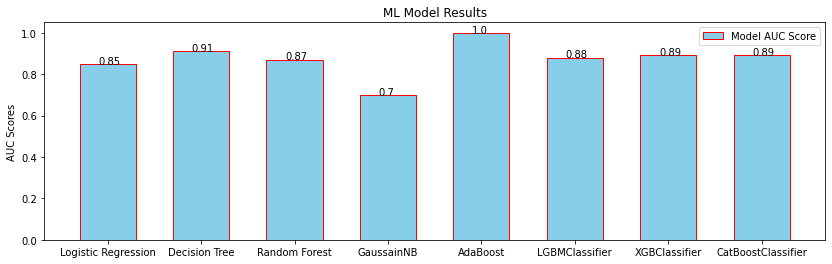

In [56]:
# sns.barplot(y=list(my_models_score.keys()),x=scores)

plt.figure(figsize = (14,4))
names = list(my_models_score.keys())

plt.bar(names, scores, width= 0.6, align='center',color='skyblue', edgecolor = 'red')

# This is the location for the annotated text
i = 0
j = 0

for i in range(len(names)):
    plt.annotate(scores[i], (-0.1 + i, scores[i] + j))

plt.legend(labels = ['Model AUC Score'])

plt.title("ML Model Results")

# plt.xlabel('Model Name')
plt.ylabel('AUC Scores')

plt.show()

Selecting Top Models and using KFold Strategy & Hyperparameter Tuning

In [57]:
from sklearn.utils import class_weight
class_weight.compute_class_weight('balanced', np.unique(y_data), y_data.values)

array([0.65363339, 2.12725047])

In [60]:
# import xgboost as xgb
# def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(dtrain.values, label=predictors.values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
#     alg.fit(dtrain, predictors,eval_metric='auc')
        
#     #Predict training set:
#     dtrain_predictions = alg.predict(dtrain)
#     dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
#     #Print model report:
#     print("\nModel Report")
#     print("Accuracy : %.4g" % sklearn.metrics.accuracy_score(predictors.values, dtrain_predictions))
#     print("AUC Score (Train): %f" % sklearn.metrics.roc_auc_score(predictors, dtrain_predprob))
    
#     return alg
# #     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
# #     feat_imp.plot(kind='bar', title='Feature Importances')
# #     plt.ylabel('Feature Importance Score')


In [61]:
# xgb1 = XGBClassifier(
#  learning_rate =0.01,
#  n_estimators=5000,
#  max_depth=4,
#  min_child_weight=6,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  reg_alpha=0.005,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)
# lgb_model = modelfit(xgb1, X_data, y_data)

# pred = lgb_model.predict_proba(X_valid)[:,1]

# roc_score = roc_auc_score(y_valid,pred)
# print(roc_score)

In [694]:
# lgb_params= {'learning_rate': 0.045, 
#              'n_estimators': 20000, 
#              'max_bin': 94,
#              'objective':"binary:logistic",
#              'nthread':4,
#              'num_leaves': 10, 
#              'max_depth': 27, 
#              'reg_alpha': 8.457, 
#              'reg_lambda': 6.853, 
#              'subsample': 0.749}


# # lgb_model = cross_val(X, y, LGBMClassifier, lgb_params) #for cross validation

# # lgb_model1 = LGBMClassifier(**lgb_params).fit(X_data,y_data,eval_set=[(X_valid, y_valid)],early_stopping_rounds=100,verbose=400)
# # lgb_model = LGBMClassifier().fit(X_data,y_data,eval_set=[(X_valid, y_valid)],early_stopping_rounds=100,verbose=400)

# pred = lgb_model.predict_proba(X_valid)[:,1]

# roc_score = roc_auc_score(y_valid,pred)
# print(roc_score)

0.8796460112589851


In [62]:
# xgb_params= {'n_estimators': 20000, 
#              'max_depth': 6, 
#              'learning_rate': 0.0201, 
#              'reg_lambda': 29.326, 
#              'subsample': 0.818, 
#              'colsample_bytree': 0.235, 
#              'colsample_bynode': 0.820, 
#              'colsample_bylevel': 0.453,
#              'class_weight': 'balanced'}


# # # xgb_model = cross_val(X, y, XGBClassifier, xgb_params)

# xgb_model = XGBClassifier(**xgb_params).fit(X_train,y_train,eval_set=[(X_valid, y_valid)],early_stopping_rounds=100,verbose=400)
# # xgb_model = XGBClassifier(class_weight='balanced').fit(X_data,y_data,verbose=400)

# # pred = xgb_model.predict_proba(X_valid)[:,1]
# # roc_score = sklearn.metrics.roc_auc_score(y_valid,pred)
# # print(roc_score)

In [63]:
# cat_params= {'n_estimators': 20000, 
#                   'depth': 4, 
#                   'learning_rate': 0.023, 
#                   'colsample_bylevel': 0.655, 
#                   'bagging_temperature': 0.921, 
#                   'l2_leaf_reg': 10.133}


# # # cat_model = cross_val(X, y, CatBoostClassifier, cat_params)

# cat_model = CatBoostClassifier(**cat_params).fit(X_train,y_train,eval_set=[(X_valid, y_valid)],early_stopping_rounds=100,verbose=400)
# # # cat_model = CatBoostClassifier().fit(X_data,y_data,verbose=400)

# # pred = cat_model.predict_proba(X_valid)[:,1]
# # roc_score = sklearn.metrics.roc_auc_score(y_valid,pred)
# # print(roc_score)

In [605]:
# rfc = RandomForestClassifier(min_samples_split= 1800,
#                n_estimators= 300,
#                criterion= 'entropy',
#                max_depth= 36,
#                min_samples_leaf=810, 
#                random_state=100)
# rfc.fit(X_data,y_data)
# y_pred = rfc.predict_proba(X_valid)[:,1]
# score = sklearn.metrics.roc_auc_score(y_valid,y_pred)
# print(score)

In [606]:
# generate_auc_roc_curve(rfc, X_valid)

## Tensorflow Part (Not used because not good AUC score)

In [ ]:
# normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
# normalizer.adapt(X_train)
# print(normalizer.mean.numpy())

In [ ]:
# # initial_bias = np.log([pos/neg])
# # output_bias = tf.keras.initializers.Constant(initial_bias)

# model = tf.keras.Sequential([
# #     normalizer,
#     tf.keras.layers.Dense(64, activation='relu',input_shape=(X_train.shape[-1],)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(units= 32, activation = "relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(units= 32, activation = "relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(units= 16, activation = "relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1,activation='sigmoid')#,bias_initializer=output_bias)

# ])

# METRICS = [
#       tf.keras.metrics.TruePositives(name='tp'),
#       tf.keras.metrics.FalsePositives(name='fp'),
#       tf.keras.metrics.TrueNegatives(name='tn'),
#       tf.keras.metrics.FalseNegatives(name='fn'), 
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),
#       tf.keras.metrics.AUC(name='auc'),
#       tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
# ]

# model.compile(
#     optimizer= "adam",#tf.optimizers.Adam(lr=1e-4), #tf.keras.optimizers.RMSprop(0.001),
#     loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
#     metrics=METRICS
#     ) 

# model.summary()

In [ ]:
# %%time
# epochs = 50

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_auc', 
#     verbose=1,
#     patience=5,
#     mode='max',
#     restore_best_weights=True)

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=10, min_lr=0.0001)


# history = model.fit(
#     X_data, y_data,
# #     X,y,
#     epochs=epochs,
#     # suppress logging
#     verbose=1,
#     batch_size=512,
# #     class_weight = {0:0.4,1:0.6},
#     validation_data = (X_valid,y_valid),
#     callbacks=[early_stopping])


In [ ]:
# plot_metrics(history)

Future in Autoencoders: https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

For Test Dataset

In [168]:
# val_pred = model.predict(X_test)[:,-1]

# #logistic
# y_pred_lr = lr.predict_proba(X_test)[:,1]

#Decision Tree
# y_pred_dtr = dtr_model.predict_proba(X_test)[:,1]

# #Gaussain
# y_pred_gnb = gnb_model.predict_proba(X_test)[:,1]

# #Random Forest
# y_pred_rfc = rfc.predict_proba(X_test)[:,1]

# #Cat Boost
# pred_test_cat = cat_model.predict_proba(X_test)[:,1]

# #XG Boost
# pred_test_xgb = xgb_model.predict_proba(X_test)[:,1]

# # LGB
# pred_test_lgb = lgb_model.predict_proba(X_test)[:,1]

# prediction = (pred_test_lgb + pred_test_cat+pred_test_xgb)/3

# y_pred_all = (val_pred+y_pred_lr+y_pred_dtr+y_pred_gnb+y_pred_rfc + pred_test_lgb + pred_test_cat+pred_test_xgb)/8

In [1]:
# my_models_score

In [64]:
top_models = ['CatBoostClassifier','LGBMClassifier','XGBClassifier','Random Forest']

#Cat Boost
cat_model = my_models_score.get(top_models[0])['model']
pred_test_cat = cat_model.predict_proba(X_test)[:,1]

# LGB
lgb_model = my_models_score.get(top_models[1])['model']
pred_test_lgb = lgb_model.predict_proba(X_test)[:,1]

#XG Boost
xgb_model = my_models_score.get(top_models[2])['model']
pred_test_xgb = xgb_model.predict_proba(X_test)[:,1]

#Random Forest
rfc = my_models_score.get(top_models[3])['model']
pred_test_rfc = rfc.predict_proba(X_test)[:,1]

prediction = (pred_test_lgb + pred_test_cat + pred_test_xgb + pred_test_rfc)/4

In [65]:
pd.DataFrame({
    'ID':test_ids,
    'Is_Lead':prediction
}).to_csv('submission.csv',index=False)

In [66]:
submission_df = pd.read_csv('./submission.csv')
submission_df.head()

,ID,Is_Lead
0,VBENBARO,0.048524
1,VK3KGA9M,0.086556
2,TT8RPZVC,0.025987
3,SHQZEYTZ,0.024162
4,MZZAQMPT,0.129523


<AxesSubplot:>

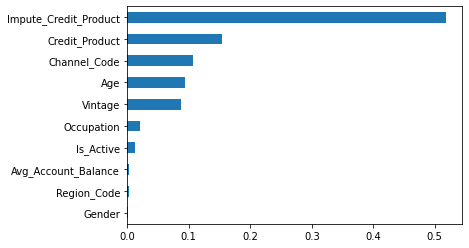

In [67]:
features = X.columns.values
t_X = pd.DataFrame(X_train)
t_X.columns = features

importances = rfc.feature_importances_
weights = pd.Series(importances,
                 index=t_X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

# Conclusions

* Trained on X_train and y_train without SMOTE with top model ON 30% test - 0.871579823300941
* Trained on X_train and y_train with SMOTE with top model on 30% test - 0.864337690604231
* Trained on X_train and y_train with Scalar without SMOTE on 30% test - 0.8716238603563875
* Trained on X and y with SMOTE with top models - 
* Trained on X and y without SMOTE with top models
* Trained on X and y with Scalar with SMOTE with top models
* 